**Exercícios Rotulação de Componentes Conexos**
exercícios obtidos em http://homepages.inf.ed.ac.uk/rbf/HIPR2/label.htm


1. Implemente o algoritmo de rotulação de componentes conexos (algoritmo do slide ou por outra solução) e aplique sobre a imagem binária art8.png. Indique qual vizinhança será considerada (4 ou 8)
Mostre os resultados na forma da imagem art8lab1.png e art8lab2.png

art8.png: 
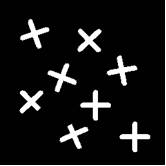
art8lab1.png: 
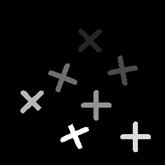
art8lab2.png: 
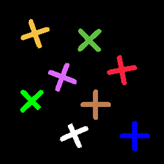
		

In [10]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
from os import path

def getLocalTime():
    named_tuple = time.localtime() # get struct_time
    return time.strftime("%d/%m/%Y, %H:%M:%S", named_tuple)

class GrayImageManipulator:
    BLACK = 0
    WHITE = 255

    def __init__(self, path = '', quantization = 8, debug = False) -> None:
        self.path = path
        self.quantization = quantization
        self.debug = debug
        self.result = None
        self.image = None

    def log(self, content, *args):
        print('[%s] %s: ' % (getLocalTime(), content), *args)
    
    def logImageSize(self):
        self.log('Image size', self.image.shape)

    def disableDebug(self) -> None:
        self.debug = False

    def enableDebug(self) -> None:
        self.debug = True

    def setPath(self, path) -> None:
        self.path = path

    def getPath(self, path):
        return path

    def setImage(self, image) -> None:
        self.image = image

    def getImage(self):
        return self.image

    def getResult(self):
        return self.result

    def configImage(self):
        image = cv2.imread(self.path, cv2.IMREAD_GRAYSCALE)

        if not path.isfile(self.path):
            raise TypeError('The path does not match any file')

        if image is None:
            raise TypeError('The path does not match any image')
        
        self.image = image

    def show(self, mode = 'sync') -> None:
        if self.image is None:
            self.configImage()
            
            if self.debug:
                self.logImageSize()
            
        self.showImage(self.image, mode = mode)    
    
    def requantize(self, newQuantization, condition = None) -> None:
        if self.image is None:
            self.configImage()

        if self.quantization < newQuantization:
            raise ValueError('The new quantization must be less than: %s' % self.quantization)

        self.newQuantization = newQuantization

        if self.debug:
            self.log('New quantization', 2**newQuantization)
            self.logImageSize()

        if condition is None:
            newImage = np.floor((self.image / (2**(self.quantization - newQuantization))))
            self.result = newImage / (2**(newQuantization)-1) * 255
        else:
            self.result = np.zeros(self.image.shape)
            height, width = self.image.shape
            for i in range(0, height):
                for j in range(0, width):
                    self.result[i][j] = condition(self.image[i][j])
                
    def binarify(self, condition = None):
        self.requantize(1, condition)
    
    def identifyComponents(self, qcondition):
        if self.image is None:
            self.configImage()

        labeledImage = np.zeros(self.image.shape)
        self.qcondition = qcondition
        self.componentsNum = self.labeler(labeledImage, 1)

        self.result = labeledImage * 255 / self.componentsNum

    def labeler(self, labeledImage, label):
        height, width = self.image.shape
        neighbors = []
        point = current = {}
        for i in range(1, height - 1):
            for j in range(1, width - 1):
                point = { 'x': i, 'y': j }

                if self.ableToLabel(self.image, labeledImage, point):
                    labeledImage[i][j] = label

                    # Empilha o ponto atual da imagem
                    neighbors.append(point)
                    while len(neighbors) > 0:
                        # desempilha os visinhos
                        current = neighbors.pop()

                        point = {
                            'x': current['x'] - 1,
                            'y': current['y']
                        }

                        # procura por vizinhos acima que respeitam a condição Q
                        self.labelNeighbors(labeledImage, point, neighbors, label)

                        point = {
                            'x': current['x'] + 1,
                            'y': current['y'],
                        }

                        # procura por vizinhos abaixo que respeitam a condição Q
                        self.labelNeighbors(labeledImage, point, neighbors, label)

                        point = {
                            'x': current['x'],
                            'y': current['y'] - 1,
                        }

                        # procura por vizinhos a esquerda que respeitam a condição Q
                        self.labelNeighbors(labeledImage, point, neighbors, label)

                        point = {
                            'x': current['x'],
                            'y': current['y'] + 1,
                        }

                        # procura por vizinhos a direita que respeitam a condição Q
                        self.labelNeighbors(labeledImage, point, neighbors, label)
                    label += 1
                    print(label)

        return label - 1


    def labelNeighbors(self, labeledImage, point, neighbors, label):
        if self.ableToLabel(self.image, labeledImage, point):
            labeledImage[point['x']][point['y']] = label
            neighbors.append(point)

    def colorCriterion(self, image, point):
        height, width = image.shape
        return point['x'] >= 0 \
            and point['y'] >= 0 \
            and point['x'] < height \
            and point['y'] < width \
            and self.qcondition(image[point['x']][point['y']])

    def unlabeled(self, labeledImage, point):
        return labeledImage[point['x']][point['y']] == 0

    def ableToLabel(self, image, labeledImage, point):
        return self.colorCriterion(image, point) and self.unlabeled(labeledImage, point)

    def showImage(self, image, cmap = 'gray', mode = 'sync') -> None:
        ax = plt.subplots()[1]
        ax.imshow(image, cmap = cmap, vmin = GrayImageManipulator.BLACK, vmax = GrayImageManipulator.WHITE)

        if self.debug:
            self.log('ploting image ...')
            
        if mode == 'sync':
            plt.show()

    def showResult(self, cmap = 'gray', mode = 'sync') -> None:
        self.validateResult()
        print(self.componentsNum)
        self.showImage(self.result, cmap = cmap, mode = mode)

    def saveResult(self, filename = 'result', cmap = 'gray', mode = 'sync') -> None:
        self.validateResult()
        print(self.componentsNum)
        
        ax = plt.subplots()[1]
        ax.imshow(self.result, cmap = cmap, vmin = GrayImageManipulator.BLACK, vmax = GrayImageManipulator.WHITE)

        if self.debug:
            self.log('saving image ...')

        plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)

        if mode == 'sync':
            plt.show()

    def validateResult(self):
        if self.result is None:
            raise ValueError('O resultado não pode ser nulo')

[09/04/2023, 00:47:30] Image size:  (256, 256)
[09/04/2023, 00:47:30] ploting image ...: 


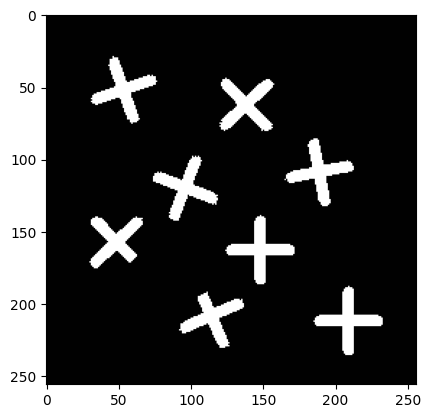

2
3
4
5
6
7
8
9
10
8
[09/04/2023, 00:47:31] saving image ...: 


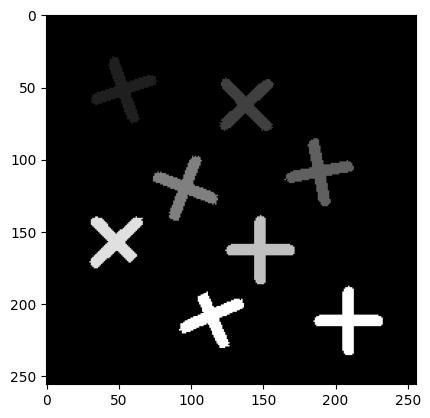

8
[09/04/2023, 00:47:32] saving image ...: 


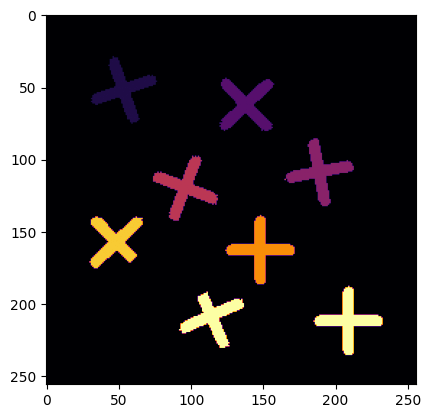

8
[09/04/2023, 00:47:32] saving image ...: 


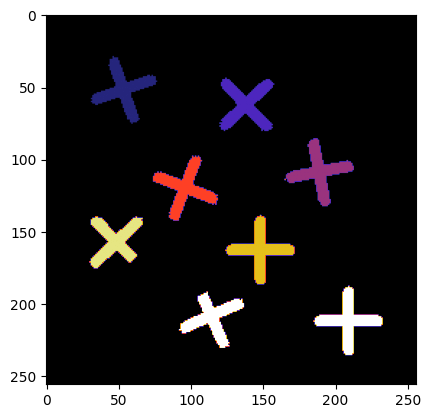

8
[09/04/2023, 00:47:33] saving image ...: 


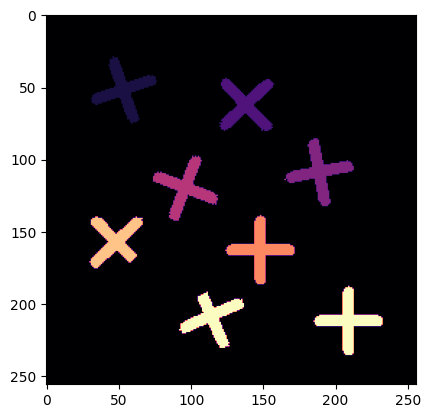

8
[09/04/2023, 00:47:34] saving image ...: 


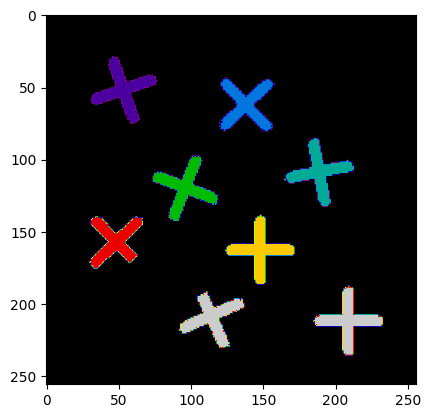

In [11]:
import logging

def main():
    try:
        image = GrayImageManipulator(path = 'art8.png', debug = True)

        image.show()
        image.identifyComponents(lambda color: color > 127)

        # image.showResult()

        image.saveResult('art8-gray.png')
        image.saveResult('art8-inferno.png', cmap='inferno')
        image.saveResult('art8-CMRmap.png', cmap='CMRmap')
        image.saveResult('art8-magma.png', cmap = 'magma')
        image.saveResult('art8-nipy_spectral.png', cmap = 'nipy_spectral')
    except Exception as e:
        logging.exception("An exception was thrown!", str(e))

main()

2. Calcule o número de objetos da imagem clc3.png. Note que antes será necessário binarizar a imagem. Para isso, considere um limiar (*threshold*) de 67, isto é, valores acima de 67 na imagem original recebem zero, e os abaixo recebem 1 (o que resulta na imagem clc3thr1.png).

clc3.png
![clc3.png](clc3.png)
clc3thr1
![clc3thr1.png](clc3thr1.png)
clc3lab1
![clc3lab1.png](clc3lab1.png)
		

[31/03/2023, 03:08:29] Image size:  (260, 200)
[31/03/2023, 03:08:29] ploting image ...: 


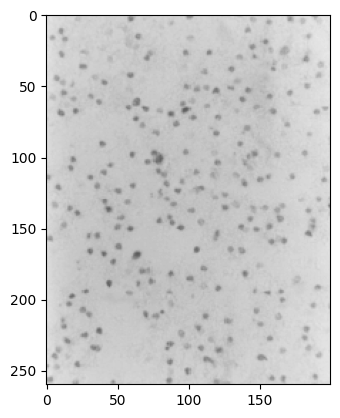

[31/03/2023, 03:08:30] New quantization:  2
[31/03/2023, 03:08:30] Image size:  (260, 200)
[31/03/2023, 03:08:30] ploting image ...: 


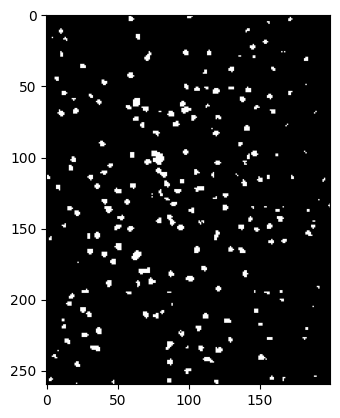

[31/03/2023, 03:08:31] ploting image ...: 


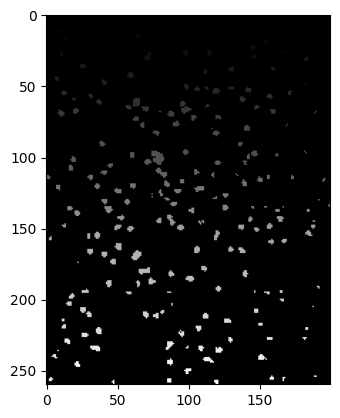

In [3]:
# code here
def main():
    image = GrayImageManipulator(path='clc3.png', debug=True)

    image.show()
    
    image.binarify(lambda color: GrayImageManipulator.WHITE if color < 167 else GrayImageManipulator.BLACK)

    image.setImage(image.getResult())

    image.show()
    image.identifyComponents(lambda color: color > 127)

    image.showResult()
    # image.saveResult('clc3-gray.png')

main()